In [1]:
import numpy as np
import cv2
from PIL import Image
import io
from skimage import io as skio
import matplotlib.pyplot as plt
from glob import glob
import os


ELA
    
    def compute_ela(img, quality=90):

    pil_img = Image.fromarray(img)
    
    buf = io.BytesIO()
    pil_img.save(buf, 'JPEG', quality=quality)
    buf.seek(0)
    resaved = Image.open(buf)
    resaved = np.array(resaved)
    
    ela_map = np.abs(img.astype(np.float32) - resaved.astype(np.float32))
    ela_map = (ela_map / ela_map.max()) * 255
    ela_map = ela_map.astype(np.uint8)
    
    return ela_map


DFT


    def compute_dft_mag_phase(gray_img):
    
    f = np.float32(gray_img)
    dft = cv2.dft(f, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    mag = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    phase = cv2.phase(dft_shift[:,:,0], dft_shift[:,:,1])
    
    mag = np.log1p(mag)
    
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    phase = (phase - phase.min()) / (phase.max() - phase.min() + 1e-8)
    
    return mag, phase


In [ ]:
# def create_img_features(img_path):

#     # Step 1: Preprocess (convert PNG, sharpen)
#     img = preprocess_img(img_path)

#     # Step 2: Convert BGR→RGB, resize
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (32, 32))

#     # Step 3: RGB normalized [0,1]
#     rgb = img.astype(np.float32) / 255.0

#     # Step 4: ELA (grayscale normalized)
#     ela = compute_ela(img)
#     ela = cv2.cvtColor(ela, cv2.COLOR_RGB2GRAY) / 255.0

#     # Step 5: Frequency features (DFT)
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     mag, phase = compute_dft_mag_phase(gray)

#     # Step 6: Stack channels
#     stacked = np.stack([rgb[...,0], rgb[...,1], rgb[...,2],
#                         mag, phase, ela], axis=-1)

#     return stacked  # shape: (32, 32, 6)


In [ ]:
# sample_path = "/content/2.png"

# features = create_img_features(sample_path)
# print("Feature shape:", features.shape)
# print("Value range:", features.min(), "→", features.max())

# titles = ['Red', 'Green', 'Blue', 'DFT Magnitude', 'DFT Phase', 'ELA']
# plt.figure(figsize=(10,4))
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.imshow(features[...,i], cmap='gray')
#     plt.title(titles[i])
#     plt.axis('off')
# plt.tight_layout()
# plt.show()


START

In [2]:
import numpy as np
import cv2
from PIL import Image
import io
import os
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data_augmentation = Sequential([
#     tf.keras.layers.RandomFlip(mode='horizontal'),
#     tf.keras.layers.RandomRotation(0.05),
#     tf.keras.layers.RandomTranslation(0.05, 0.05),
#     tf.keras.layers.RandomBrightness(0.1),
#     tf.keras.layers.RandomContrast(0.1)
# ])


In [4]:
import tensorflow as tf
import os

base_dir = '/content/drive/MyDrive/IIITB/train'
classes = ['real', 'fake']

# Augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

AUG_MULTIPLIER = 3

for class_name in classes:
    src_path = os.path.join(base_dir, class_name)
    print(f"\nProcessing folder: {src_path}")

    img_files = [f for f in os.listdir(src_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(img_files)} original images.")

    for img_name in img_files:
        img_path = os.path.join(src_path, img_name)

        img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
        img = tf.keras.utils.img_to_array(img)
        img = tf.expand_dims(img, 0)

        for i in range(AUG_MULTIPLIER):
            aug_img = data_augmentation(img)
            aug_img = tf.clip_by_value(aug_img, 0, 255)

            base_name, ext = os.path.splitext(img_name)
            save_path = os.path.join(src_path, f"{base_name}_aug{i+1}{ext}")
            tf.keras.utils.save_img(save_path, aug_img[0])

    print(f"✅ Done augmenting '{class_name}' — total new images saved: {len(img_files) * AUG_MULTIPLIER}")

print("\n🎉 All images augmented and saved successfully in the same class folders!")



Processing folder: /content/drive/MyDrive/IIITB/train/real
Found 1000 original images.
✅ Done augmenting 'real' — total new images saved: 3000

Processing folder: /content/drive/MyDrive/IIITB/train/fake
Found 1000 original images.
✅ Done augmenting 'fake' — total new images saved: 3000

🎉 All images augmented and saved successfully in the same class folders!


In [5]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/IIITB/train',
    shuffle=True,
    image_size=(32, 32),
    batch_size=32,
    labels='inferred'
)
classes = train_ds.class_names
print("Classes:", classes)


Found 8000 files belonging to 2 classes.
Classes: ['fake', 'real']


In [6]:
classes = train_ds.class_names
print('Class order:', classes)

Class order: ['fake', 'real']


In [7]:
train_size = int(0.8 * len(train_ds))
val_size = int(0.2 * len(train_ds))
train_ds = train_ds.take(train_size)
val_ds = train_ds.skip(train_size)


In [9]:
import cv2
import numpy as np
from PIL import Image
import io

def compute_ela(img, quality=90):
    pil_img = Image.fromarray(img)
    buf = io.BytesIO()
    pil_img.save(buf, 'JPEG', quality=quality)
    buf.seek(0)
    resaved = Image.open(buf)
    resaved = np.array(resaved)
    ela_map = np.abs(img.astype(np.float32) - resaved.astype(np.float32))
    ela_map = (ela_map / ela_map.max()) * 255
    ela_map = ela_map.astype(np.uint8)
    return ela_map

def compute_dft_mag_phase(gray_img):
    f = np.float32(gray_img)
    dft = cv2.dft(f, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    mag = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    phase = cv2.phase(dft_shift[:,:,0], dft_shift[:,:,1])
    mag = np.log1p(mag)
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    phase = (phase - phase.min()) / (phase.max() - phase.min() + 1e-8)
    return mag, phase

rgb_images, dft_data, labels = [], [], []
for batch in train_ds:
    imgs, lbls = batch
    batch_rgb, batch_dft = [], []
    for i in range(imgs.shape[0]):
        img = imgs[i].numpy().astype('uint8')
        img_up = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)

        batch_rgb.append(img_up)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mag, phase = compute_dft_mag_phase(gray)
        ela_map = compute_ela(img)
        ela_chan = cv2.cvtColor(ela_map, cv2.COLOR_RGB2GRAY) / 255.0

        feat = np.stack([mag, phase, ela_chan], axis=-1)
        batch_dft.append(feat)

    rgb_images.append(np.stack(batch_rgb))
    dft_data.append(np.stack(batch_dft))
    labels.append(lbls.numpy())

rgb_images = np.concatenate(rgb_images)
dft_data = np.concatenate(dft_data)
labels = np.concatenate(labels)
print(rgb_images.shape, dft_data.shape, labels.shape)


(6400, 224, 224, 3) (6400, 32, 32, 3) (6400,)


In [10]:
from sklearn.model_selection import train_test_split
X_train_rgb, X_val_rgb, X_train_dft, X_val_dft, y_train, y_val = train_test_split(
    rgb_images, dft_data, labels, test_size=0.2, random_state=42, stratify=labels)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D, Conv2D, MaxPooling2D,
                                     Concatenate, GaussianNoise)
from tensorflow.keras.models import load_model

In [18]:
tuner_params = {
    'dropout_dense1': [0.3, 0.4, 0.5],
    'dropout_dense2': [0.2, 0.3, 0.4],
    'l2_reg': [1e-2, 1e-3, 1e-4],
    'lr': [1e-3, 5e-4, 1e-4],
    'batch_size': [8, 16, 32],
    'gaussian_noise_std': [0.05, 0.1, 0.2],
    'label_smoothing': [0.0, 0.05, 0.1],
}


In [13]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [19]:
import keras_tuner as kt
from tensorflow.keras import regularizers

def build_model(hp):
    dropout_dense1 = hp.Choice('dropout_dense1', [0.3, 0.4, 0.5])
    dropout_dense2 = hp.Choice('dropout_dense2', [0.2, 0.3, 0.4])
    l2_reg = hp.Choice('l2_reg', [1e-2, 1e-3, 1e-4])
    gaussian_noise_std = hp.Choice('gaussian_noise_std', [0.05, 0.1, 0.2])
    lr = hp.Choice('lr', [1e-3, 5e-4, 1e-4])
    label_smoothing = hp.Choice('label_smoothing', [0.0, 0.05, 0.1])

    rgb_input = Input(shape=(224,224,3), name='rgb_input')
    base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_tensor=rgb_input)
    base_model.trainable = False

    x_rgb = GlobalAveragePooling2D()(base_model.output)
    x_rgb = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x_rgb)
    x_rgb = Dropout(dropout_dense1)(x_rgb)
    x_rgb = BatchNormalization()(x_rgb)
    x_rgb = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x_rgb)
    x_rgb = Dropout(dropout_dense2)(x_rgb)

    dft_input = Input(shape=(32, 32, 3), name='dft_input')
    x_dft = Conv2D(32, (3,3), activation='relu', padding='same')(dft_input)
    x_dft = MaxPooling2D((2,2))(x_dft)
    x_dft = BatchNormalization()(x_dft)
    x_dft = Conv2D(64, (3,3), activation='relu', padding='same')(x_dft)
    x_dft = MaxPooling2D((2,2))(x_dft)
    x_dft = BatchNormalization()(x_dft)
    x_dft = Conv2D(128, (3,3), activation='relu', padding='same')(x_dft)
    x_dft = GlobalAveragePooling2D()(x_dft)
    x_dft = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x_dft)
    x_dft = Dropout(dropout_dense1)(x_dft)

    merged = Concatenate()([x_rgb, x_dft])
    merged = GaussianNoise(gaussian_noise_std)(merged)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(merged)
    x = Dropout(dropout_dense1)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_dense2)(x)
    output = Dense(1, activation='sigmoid')(x)

    loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

    model = tf.keras.Model(inputs=[rgb_input, dft_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=loss_fn,
                  metrics=['accuracy'])
    return model


In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_tunned.h5', monitor='val_loss', save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]

In [21]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='deepfake_hybrid_tuning'
)

tuner.search(
    [X_train_rgb, X_train_dft], y_train,
    validation_data=([X_val_rgb, X_val_dft], y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks
)
best_model = tuner.get_best_models(1)[0]


Trial 10 Complete [00h 03m 25s]
val_accuracy: 0.9468749761581421

Best val_accuracy So Far: 0.949999988079071
Total elapsed time: 00h 32m 37s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

In [31]:
print('dropout_dense1: ',best_hps.get('dropout_dense1'))
print('dropout_dense2: ',best_hps.get('dropout_dense2'))
print('l2_reg: ',best_hps.get('l2_reg'))
print('lr: ',best_hps.get('lr'))
print('gaussian_noise_std: ',best_hps.get('gaussian_noise_std'))
print('label_smoothing: ',best_hps.get('label_smoothing'))

dropout_dense1:  0.3
dropout_dense2:  0.4
l2_reg:  0.01
lr:  0.0001
gaussian_noise_std:  0.2
label_smoothing:  0.05


In [23]:
train_loss, train_accuracy = best_model.evaluate([X_train_rgb, X_train_dft], y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9734


In [32]:
val_loss, val_accuracy = best_model.evaluate([X_val_rgb, X_val_dft], y_val, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9500


In [27]:
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report

y_val_probs = best_model.predict([X_val_rgb, X_val_dft]).flatten()
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print(f'Best threshold: {best_threshold:.3f}')

y_val_pred = (y_val_probs >= best_threshold).astype(int)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification report:\n", classification_report(y_val, y_val_pred))


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step
Best threshold: 0.509
Accuracy: 0.95078125
Confusion matrix:
 [[604  33]
 [ 30 613]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       637
           1       0.95      0.95      0.95       643

    accuracy                           0.95      1280
   macro avg       0.95      0.95      0.95      1280
weighted avg       0.95      0.95      0.95      1280



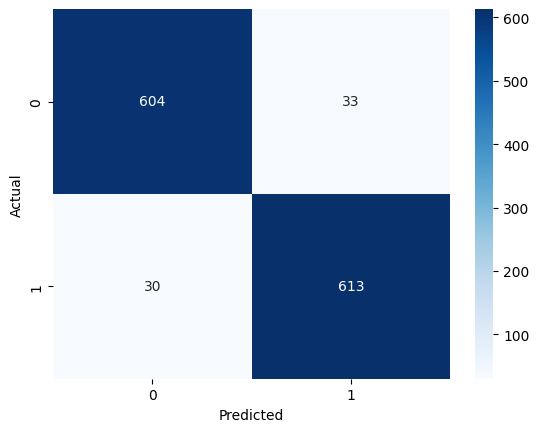

In [28]:
cm = confusion_matrix(y_val, y_val_pred)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [33]:
test_rgb = []
test_dft = []
test_paths = sorted(glob('/content/drive/MyDrive/IIITB/test/*.png'))
for img_path in test_paths:
    img = cv2.imread(img_path)
    img_up = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
    test_rgb.append(img_up)
    img_small = cv2.resize(img, (32,32))
    gray = cv2.cvtColor(img_small, cv2.COLOR_RGB2GRAY)
    mag, phase = compute_dft_mag_phase(gray)
    ela_map = compute_ela(img_small)
    ela_chan = cv2.cvtColor(ela_map, cv2.COLOR_RGB2GRAY) / 255.0
    feat = np.stack([mag, phase, ela_chan], axis=-1)
    test_dft.append(feat)
test_rgb = np.stack(test_rgb)
test_dft = np.stack(test_dft)
test_probs = best_model.predict([test_rgb, test_dft]).flatten()
test_preds = (test_probs >= best_threshold).astype(int)

import json
out_json = [{"index": i+1, "prediction": ("fake" if pred==1 else "real")} for i, pred in enumerate(test_preds)]
with open("teamname_prediction.json", "w") as f:
    json.dump(out_json, f, indent=2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


In [35]:
best_model.save("Deepfake_classif.h5")


In [39]:
cnt0 = 0
cnt1 = 0
for i in test_preds:
  if i == 0:
    cnt0+=1
  else:
    cnt1+=1
print("real: ",cnt1)
print("fake: ",cnt0)

real:  179
fake:  245
